In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import pickle
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# West coast
links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+JOSE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+CLARA&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SUNNYVALE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MOUNTAIN+VIEW&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=CUPERTINO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=MENLO+PARK&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=PALO+ALTO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDWOOD+CITY&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+MATEO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SAN+FRANCISCO&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SEATTLE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDMOND&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SANTA+MONICA&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=LOS+ANGELES&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=AUSTIN&year=All+Years',
         'https://h1bdata.info/index.php?em=amazon&job=Data+Scientist+I&city=&year=All+Years'
        ]


In [25]:
# Boston and Seattle
links = ['https://h1bdata.info/index.php?em=&job=Data+Scientist&city=BOSTON&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SEATTLE&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=REDMOND&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=ROCHESTER&year=All+Years',
         'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=SYRACUSE&year=All+Years'
        ]


In [26]:
jobs_list = []
for link in links:
    page_link = link
    page_response = requests.get(page_link, timeout=1000)
    page_content = BeautifulSoup(page_response.content, "lxml")
    
    for row in page_content.find_all("tr")[1:]:
        row_data = []
        for i in row:
            row_data.append(i.text)
        jobs_list.append(row_data)

In [27]:
#put everything into a dataframe for processing easily
ds_jobs_df = pd.DataFrame()
ds_jobs_df['company'] = [i[0] for i in jobs_list]
ds_jobs_df['title'] = [i[1] for i in jobs_list]
ds_jobs_df['salary'] = [i[2].replace(',','') for i in jobs_list]
ds_jobs_df['salary'] = ds_jobs_df['salary'].astype(float)
ds_jobs_df['location'] = [i[3] for i in jobs_list]
ds_jobs_df['date'] = [i[4] for i in jobs_list]
ds_jobs_df['date'] = pd.to_datetime(ds_jobs_df['date'])
ds_jobs_df['year'] = [i.year for i in ds_jobs_df['date']]

#Drop pre 2014 data (very few obseravations pre 2014)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['year']<2014].index, axis=0, inplace=True)

#Drop salaries over $1,000,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']>1000000].index, axis=0, inplace=True)

#Sort by company and year
ds_jobs_df.sort_values(by=['year', 'company'], inplace=True, ascending=True)

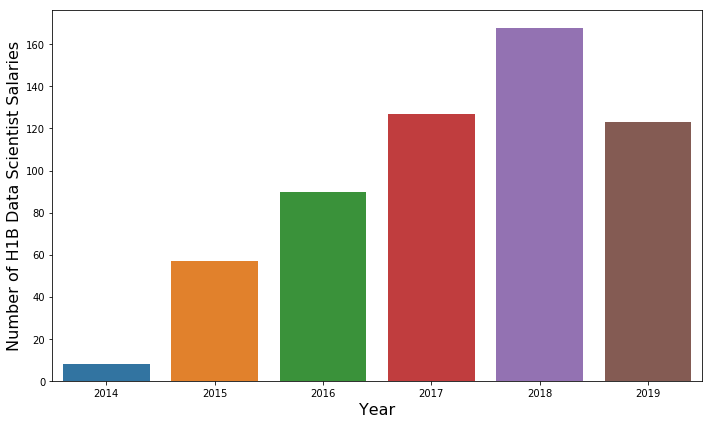

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=ds_jobs_df['year'].value_counts().sort_index().index,
                 y=ds_jobs_df['year'].value_counts().sort_index().values)
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Number of H1B Data Scientist Salaries", fontsize=16)
plt.tight_layout()

In [29]:
ds_jobs_df['salary'].median()

113152.0

In [30]:
median_salary = ds_jobs_df.groupby(by=['year']).median().reset_index()
median_salary

,year,salary
0,2014,110191.5
1,2015,107100.0
2,2016,119000.0
3,2017,115000.0
4,2018,115000.0
5,2019,95160.0


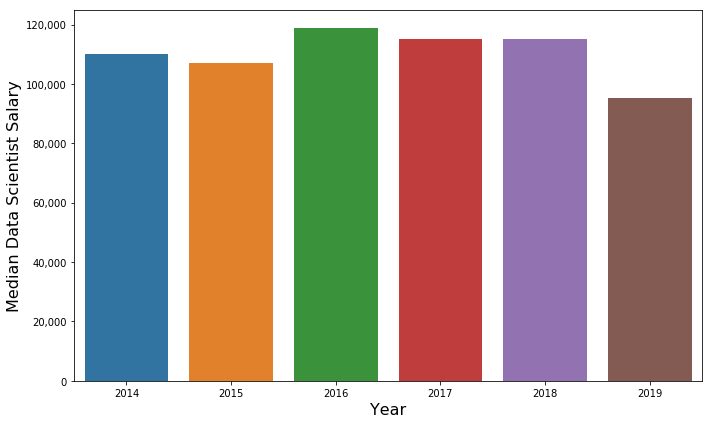

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=median_salary['year'],
                 y=median_salary['salary'])
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Median Data Scientist Salary", fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

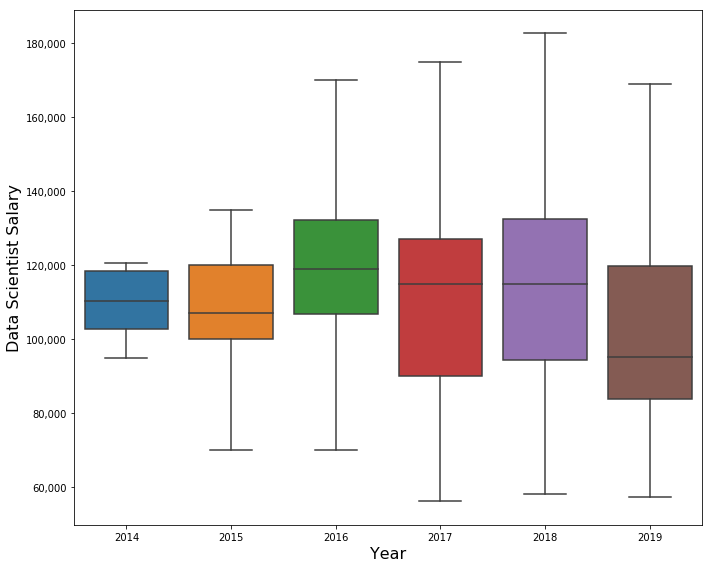

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.boxplot(x='year', y='salary', data=ds_jobs_df, showfliers=False);
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Data Scientist Salary", fontsize=16)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

In [33]:
print("All 25th perctile:", ds_jobs_df['salary'].quantile(0.25))
print("All 25th perctile: " + str(ds_jobs_df['salary'].quantile(0.5)))
print("All 25th perctile: " + str(ds_jobs_df['salary'].quantile(0.75)))

All 25th perctile: 90351.0
All 25th perctile: 113152.0
All 25th perctile: 127000.0


In [34]:
print('2015 25th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']==2015]['salary'].quantile(0.25)))
print('2015 50th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']==2015]['salary'].quantile(0.50)))
print('2015 75th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']==2015]['salary'].quantile(0.75)))

2015 25th perctile: 100000.0
2015 50th perctile: 107100.0
2015 75th perctile: 120000.0


In [35]:
print('2019 25th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']>=2019]['salary'].quantile(0.25)))
print('2019 50th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']>=2019]['salary'].quantile(0.50)))
print('2019 75th perctile: ' + str(ds_jobs_df[ds_jobs_df['year']>=2019]['salary'].quantile(0.75)))

2019 25th perctile: 83849.0
2019 50th perctile: 95160.0
2019 75th perctile: 119850.0


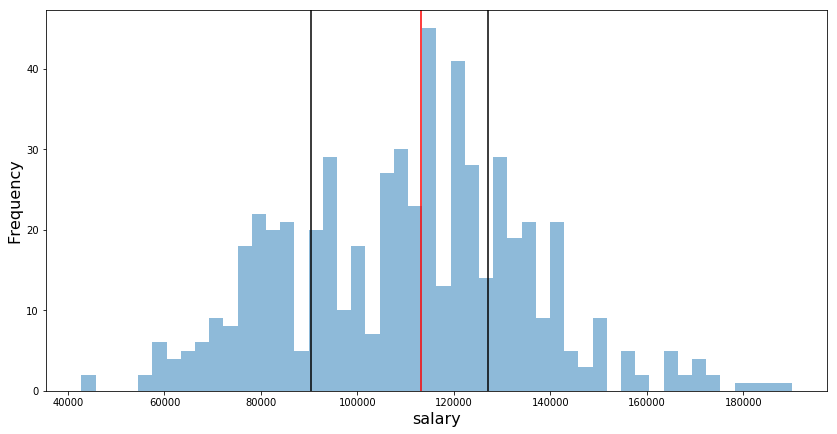

In [36]:
fig, ax = plt.subplots(figsize=(14,7))
ax = plt.hist(ds_jobs_df['salary'], bins=50, alpha=0.5)
plt.axvline(ds_jobs_df['salary'].quantile(0.25), c='black')
plt.axvline(ds_jobs_df['salary'].quantile(0.5), c='red')
plt.axvline(ds_jobs_df['salary'].quantile(0.75), c='black')

plt.xlabel('salary', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()

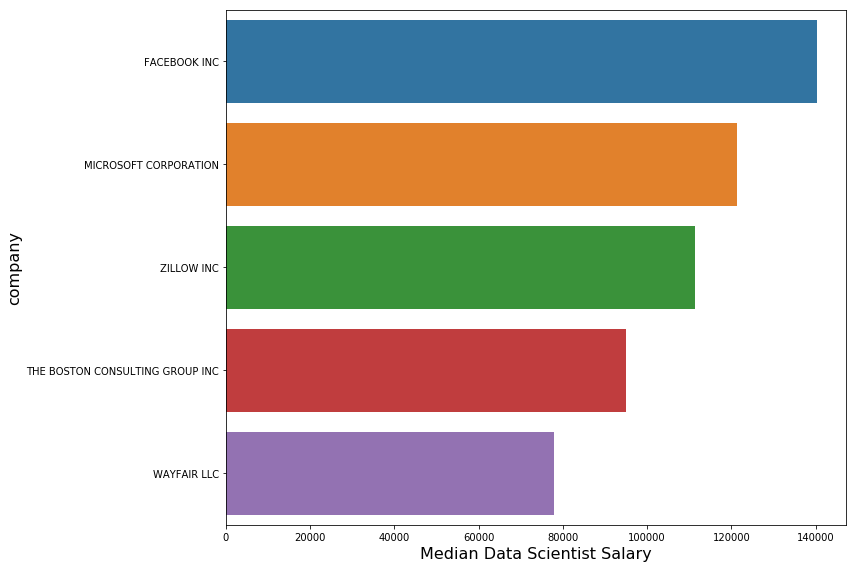

In [37]:
company_df = pd.DataFrame()
company_df['company'] = ds_jobs_df[['company','salary']].groupby(by=['company']).count().reset_index()['company']
company_df['count'] = ds_jobs_df[['company','salary']].groupby(by=['company']).count().reset_index()['salary']
company_df['salary'] = ds_jobs_df[['company','salary']].groupby(by=['company']).median().reset_index()['salary']
sorted_df = company_df.sort_values(by='salary', ascending=False)
sorted_df = sorted_df[sorted_df['count']>=10]

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=sorted_df['salary'],
                 y=sorted_df['company'])
ax.set_xlabel("Median Data Scientist Salary", fontsize=16)
ax.set_ylabel("company", fontsize=16)
plt.tight_layout()

In [38]:
sorted_df.iloc[0:10]

,company,count,salary
52,FACEBOOK INC,35,140250.0
85,MICROSOFT CORPORATION,203,121367.0
141,ZILLOW INC,14,111390.0
126,THE BOSTON CONSULTING GROUP INC,17,95000.0
138,WAYFAIR LLC,24,77854.0


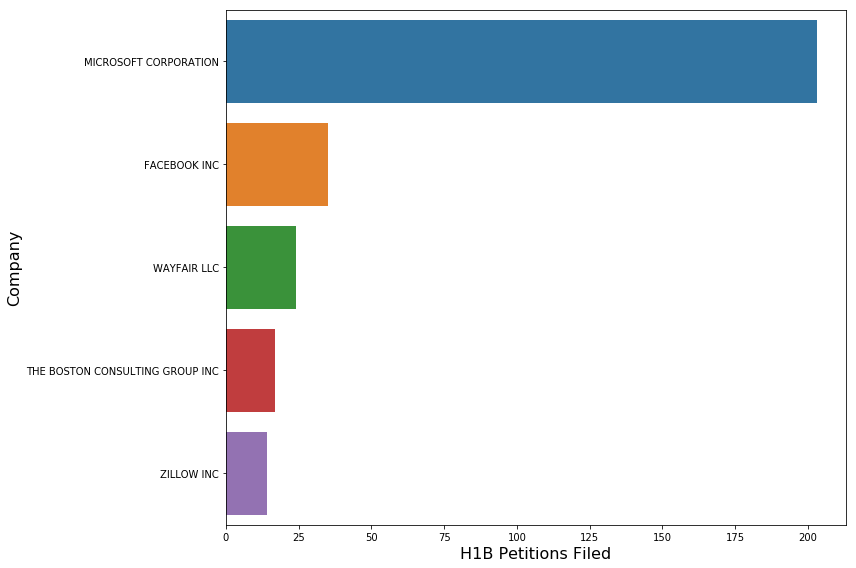

In [39]:
sorted_df = company_df.sort_values(by='count', ascending=False)
sorted_df = sorted_df[sorted_df['count']>=10]

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x=sorted_df['count'],
                 y=sorted_df['company'])
ax.set_xlabel("H1B Petitions Filed", fontsize=16)
ax.set_ylabel("Company", fontsize=16)
plt.tight_layout()